# Heart Failure Prediction using Machine Learning

## Project Overview
This project aims to predict the presence of heart disease in patients using various machine learning classification models. The dataset contains 12 clinical features such as age, cholesterol, chest pain type, and ECG results.

## Objectives
- Perform exploratory data analysis (EDA)
- Preprocess the data (handle missing values, encoding, scaling)
- Train and evaluate 7 classification models:
  1. Logistic Regression
  2. K-Nearest Neighbors (K-NN)
  3. Support Vector Machine (SVM)
  4. Kernel SVM
  5. Naive Bayes
  6. Decision Tree
  7. Random Forest
- Compare model performance and identify the best classifier

## Dataset Source
Kaggle: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

# Import all required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

# Sklearn imports
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV, cross_validate
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer # Import SimpleImputer from sklearn.impute
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve, classification_report,
    confusion_matrix, brier_score_loss, average_precision_score
)
from sklearn.dummy import DummyClassifier
from sklearn.inspection import permutation_importance

# Calibration
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

# Model persistence
import joblib

# For Cramer's V
import scipy.stats as stats

# Set random state
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Set plot style
plt.style.use('default')
sns.set_palette("Set2")


# Load dataset

In [2]:
df = pd.read_csv('heart.csv')
print("\nFirst 5 Rows:")
df.head()


First 5 Rows:


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


# Basic info

In [3]:
print("\nDataset Info:")
print(df.info())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
None


In [4]:
print("Dataset Shape:", df.shape)

Dataset Shape: (918, 12)


In [5]:
print("\nMissing Values:")
display(df.isnull().sum())


Missing Values:


,0
Age,0
Sex,0
ChestPainType,0
RestingBP,0
Cholesterol,0
FastingBS,0
RestingECG,0
MaxHR,0
ExerciseAngina,0
Oldpeak,0


In [6]:
print("\nDescriptive Statistics (Numerical Features):")
display(df.describe())


Descriptive Statistics (Numerical Features):


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [7]:
# Class distribution
print("\nClass Distribution (HeartDisease):")
class_dist = df['HeartDisease'].value_counts(normalize=True)
display(class_dist)


Class Distribution (HeartDisease):


,proportion
HeartDisease,
1,0.553377
0,0.446623


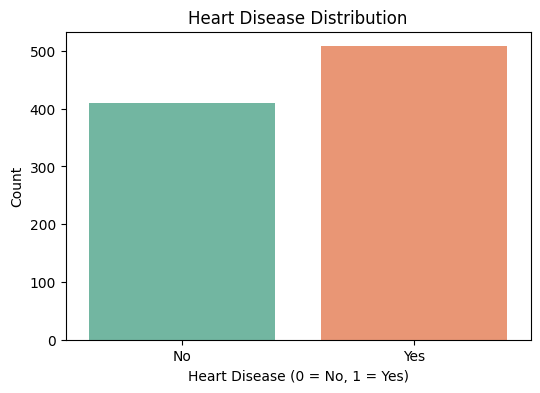

In [8]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='HeartDisease', palette='Set2')
plt.title('Heart Disease Distribution')
plt.xlabel('Heart Disease (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.xticks(ticks=[0,1], labels=['No', 'Yes'])
plt.show()

In [9]:
# Check for invalid zeros in key clinical features
zero_cols = ['RestingBP', 'Cholesterol']
for col in zero_cols:
    zero_count = (df[col] == 0).sum()
    print(f"Zeros in {col}: {zero_count}")

Zeros in RestingBP: 1
Zeros in Cholesterol: 172


# Distribution of numerical features

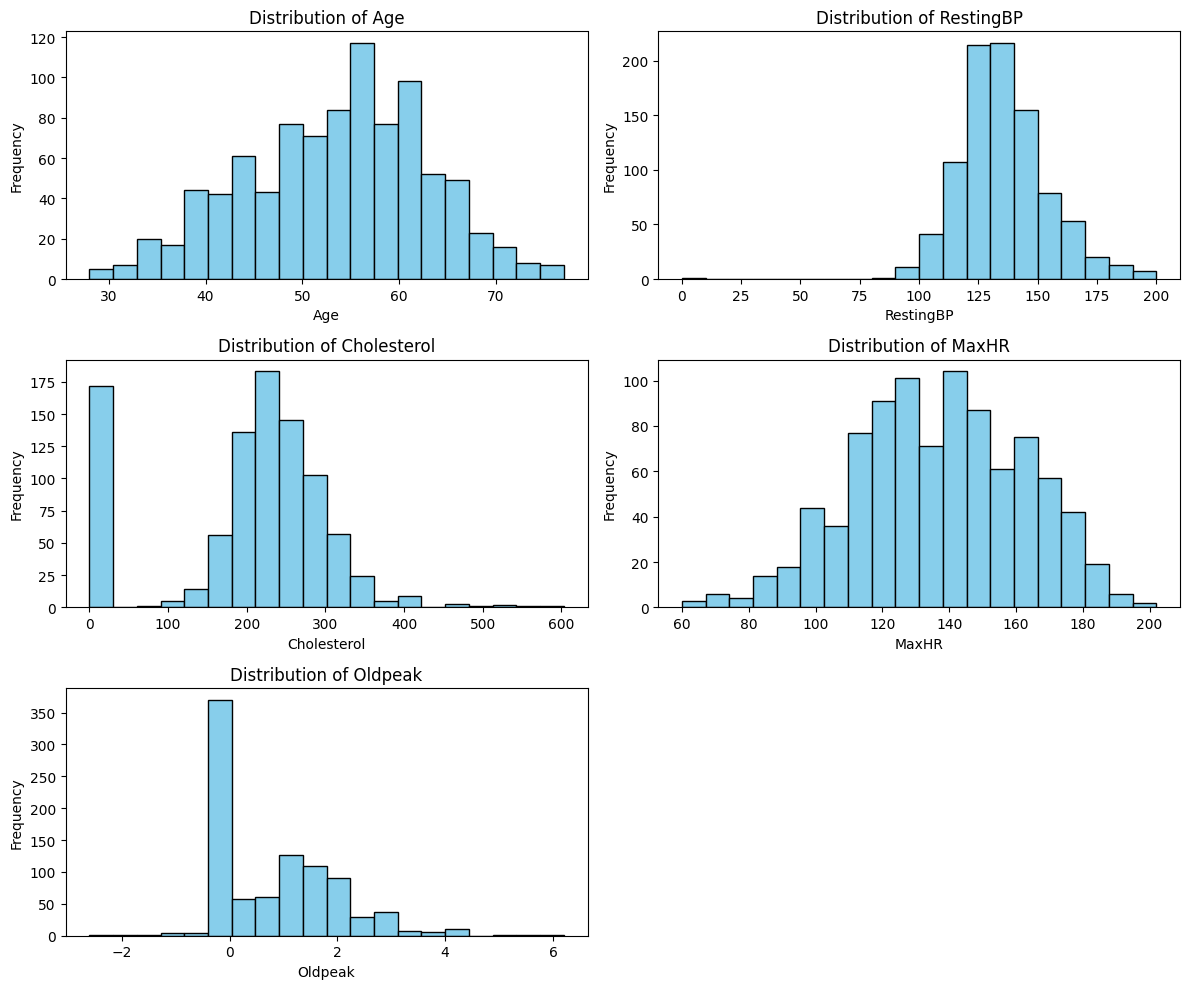

In [10]:
num_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
fig, axes = plt.subplots(3, 2, figsize=(12, 10))
for i, feature in enumerate(num_features):
    row, col = i // 2, i % 2
    axes[row, col].hist(df[feature], bins=20, color='skyblue', edgecolor='black')
    axes[row, col].set_title(f'Distribution of {feature}')
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Frequency')
axes[2, 1].axis('off')
plt.tight_layout()
plt.show()

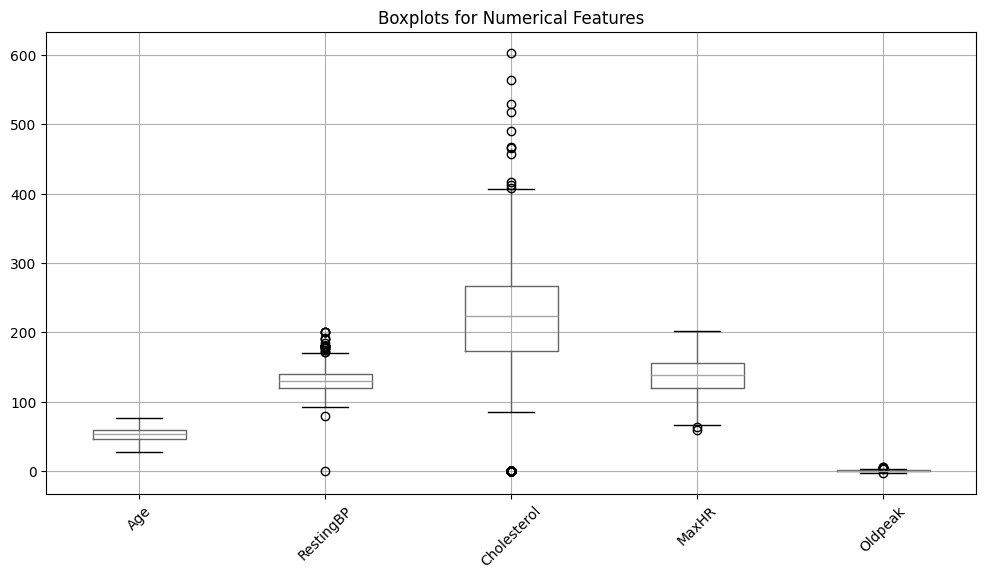

In [11]:
# Boxplots for outliers
plt.figure(figsize=(12, 6))
df[num_features].boxplot()
plt.title('Boxplots for Numerical Features')
plt.xticks(rotation=45)
plt.show()

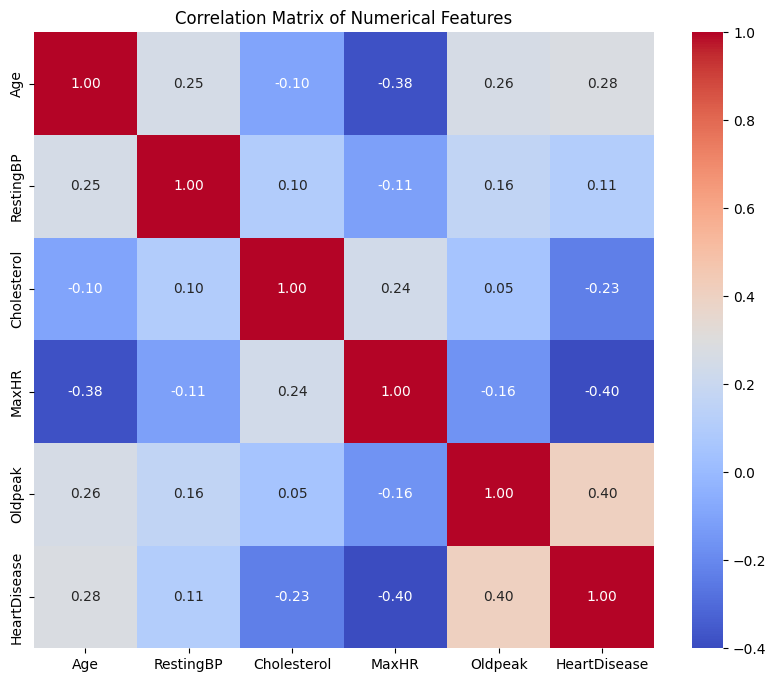

In [12]:
# Correlation matrix for numerical features
numerical_df = df[num_features + ['HeartDisease']]
plt.figure(figsize=(10, 8))
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

Categorical Feature Association with HeartDisease (Cramer's V):
          Feature  Cramer's V
5        ST_Slope    0.621249
1   ChestPainType    0.537639
4  ExerciseAngina    0.491208
0             Sex    0.301114
2       FastingBS    0.262775
3      RestingECG    0.098679


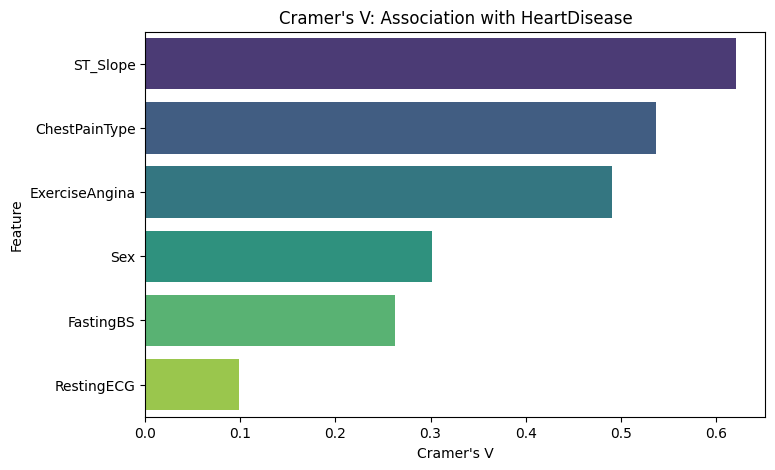

In [13]:
# Cramer's V for categorical features
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

categorical_cols = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
cramers_results = []

for col in categorical_cols:
    v = cramers_v(df[col], df['HeartDisease'])
    cramers_results.append({'Feature': col, "Cramer's V": v})

cramers_df = pd.DataFrame(cramers_results).sort_values("Cramer's V", ascending=False)
print("Categorical Feature Association with HeartDisease (Cramer's V):")
print(cramers_df)

plt.figure(figsize=(8, 5))
sns.barplot(data=cramers_df, x="Cramer's V", y='Feature', palette='viridis')
plt.title("Cramer's V: Association with HeartDisease")
plt.show()

# Baseline Model

In [14]:
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# Baseline models
dummy_strat = DummyClassifier(strategy='stratified', random_state=RANDOM_STATE)
dummy_freq = DummyClassifier(strategy='most_frequent')

dummy_strat.fit(X_train, y_train)
dummy_freq.fit(X_train, y_train)

y_pred_strat = dummy_strat.predict(X_test)
y_pred_freq = dummy_freq.predict(X_test)
y_prob_strat = dummy_strat.predict_proba(X_test)[:, 1]

metrics = {}
for name, y_pred, y_prob in [
    ('Stratified', y_pred_strat, y_prob_strat),
    ('Most Frequent', y_pred_freq, y_prob_strat)
]:
    metrics[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_prob)
    }

baseline_df = pd.DataFrame(metrics).T
print("Baseline Model Performance:")
display(baseline_df.round(3))

Baseline Model Performance:


,Accuracy,Precision,Recall,F1,ROC AUC
Stratified,0.522,0.564,0.608,0.585,0.511
Most Frequent,0.554,0.554,1.000,0.713,0.511


In [15]:
# Replace 0s with NaN
df_clean = df.copy()
df_clean['Cholesterol'] = df_clean['Cholesterol'].replace(0, np.nan)
df_clean['RestingBP'] = df_clean['RestingBP'].replace(0, np.nan)

X = df_clean.drop('HeartDisease', axis=1)
y = df_clean['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print("Missing values before imputation:")
display(X_train[['Cholesterol', 'RestingBP']].isnull().sum())

Missing values before imputation:


,0
Cholesterol,129
RestingBP,0


# Define preprocessing steps

In [16]:
numerical_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
categorical_cols = [col for col in X.columns if col not in numerical_cols]

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

In [17]:
# Fit on training data only
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("Preprocessing complete.")
print("Training set shape:", X_train_processed.shape)
print("Test set shape:", X_test_processed.shape)

Preprocessing complete.
Training set shape: (734, 15)
Test set shape: (184, 15)


In [18]:
# Save preprocessor
joblib.dump(preprocessor, 'preprocessor.pkl')
print("Preprocessor saved as 'preprocessor.pkl'")

Preprocessor saved as 'preprocessor.pkl'


#  Model Training

In [19]:
models = {}
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Logistic Regression
lr = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
lr_params = {'C': np.logspace(-4, 4, 20), 'penalty': ['l1', 'l2']}
lr_grid = GridSearchCV(lr, lr_params, cv=cv_strategy, scoring='roc_auc', n_jobs=-1)
lr_grid.fit(X_train_processed, y_train)
models['Logistic Regression'] = lr_grid.best_estimator_
print("Best LR:", lr_grid.best_params_)

# KNN
knn = KNeighborsClassifier()
knn_params = {'n_neighbors': range(1, 21)}
knn_grid = GridSearchCV(knn, knn_params, cv=cv_strategy, scoring='roc_auc', n_jobs=-1)
knn_grid.fit(X_train_processed, y_train)
models['KNN'] = knn_grid.best_estimator_
print("Best KNN:", knn_grid.best_params_)

# SVM (RBF)
svm = SVC(probability=True, random_state=RANDOM_STATE)
svm_params = {
    'C': stats.loguniform(0.01, 100),
    'gamma': stats.loguniform(0.001, 1)
}
svm_rand = RandomizedSearchCV(svm, svm_params, n_iter=50, cv=cv_strategy,
                             scoring='roc_auc', n_jobs=-1, random_state=RANDOM_STATE)
svm_rand.fit(X_train_processed, y_train)
models['SVM (RBF)'] = svm_rand.best_estimator_
print("Best SVM:", svm_rand.best_params_)

# Random Forest
rf = RandomForestClassifier(random_state=RANDOM_STATE)
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}
rf_rand = RandomizedSearchCV(rf, rf_params, n_iter=30, cv=cv_strategy,
                            scoring='roc_auc', n_jobs=-1, random_state=RANDOM_STATE)
rf_rand.fit(X_train_processed, y_train)
models['Random Forest'] = rf_rand.best_estimator_
print("Best RF:", rf_rand.best_params_)

# Other models (no tuning)
models['Naive Bayes'] = GaussianNB().fit(X_train_processed, y_train)
models['Decision Tree'] = DecisionTreeClassifier(random_state=RANDOM_STATE).fit(X_train_processed, y_train)
models['SVM (Linear)'] = SVC(kernel='linear', probability=True, random_state=RANDOM_STATE).fit(X_train_processed, y_train)


Best LR: {'C': np.float64(1.623776739188721), 'penalty': 'l2'}
Best KNN: {'n_neighbors': 17}
Best SVM: {'C': np.float64(12.130221181165163), 'gamma': np.float64(0.030296104428212477)}
Best RF: {'n_estimators': 300, 'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 15}


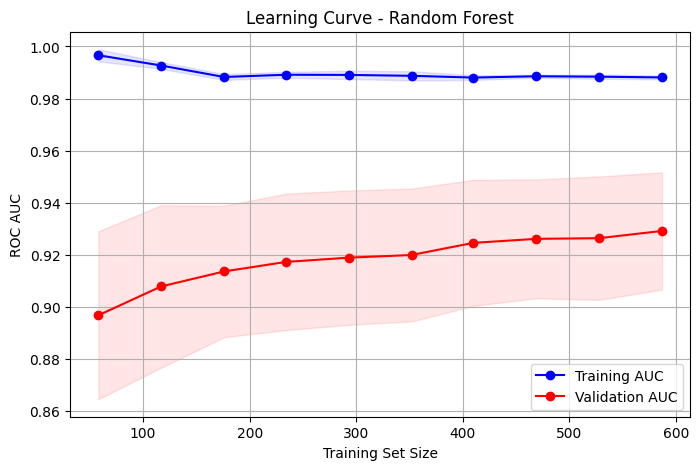

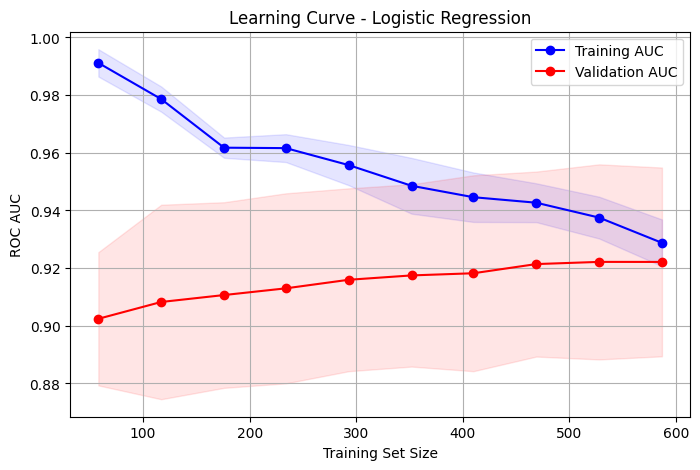

In [21]:
# Plot for Random Forest (complex) and Logistic Regression (simple)
plot_learning_curve(models['Random Forest'], X_train_processed, y_train, 'Random Forest')
plot_learning_curve(models['Logistic Regression'], X_train_processed, y_train, 'Logistic Regression')

def plot_validation_curve(estimator, X, y, param_name, param_range, title):
    train_scores, val_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=cv_strategy, scoring='roc_auc', n_jobs=-1
    )
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(8, 5))
    plt.plot(param_range, train_mean, 'o-', color='blue', label='Training AUC')
    plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.1)
    plt.plot(param_range, val_mean, 'o-', color='red', label='Validation AUC')
    plt.fill_between(param_range, val_mean - val_std, val_mean + val_std, alpha=0.1)
    plt.xlabel(param_name)
    plt.ylabel('ROC AUC')
    plt.title(f'Validation Curve - {title}')
    plt.legend()
    plt.grid(True)
    plt.show()

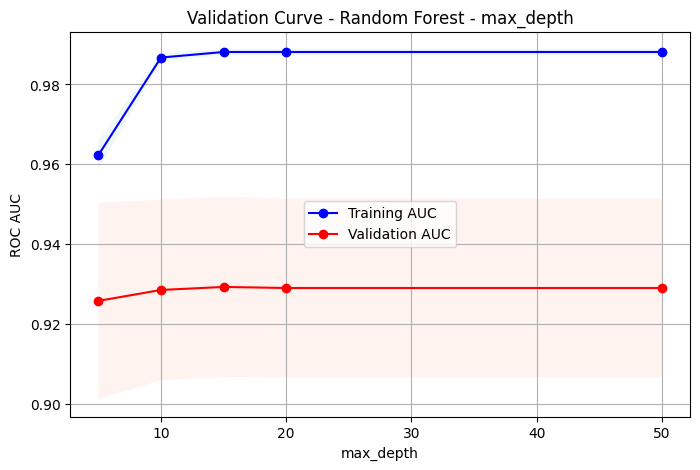

In [22]:
# For RF: max_depth

param_range = [5, 10, 15, 20, 50]  # Use 50 instead of None
plot_validation_curve(
    models['Random Forest'], X_train_processed, y_train,
    param_name='max_depth', param_range=param_range,
    title='Random Forest - max_depth'
)

# Calibration analysis

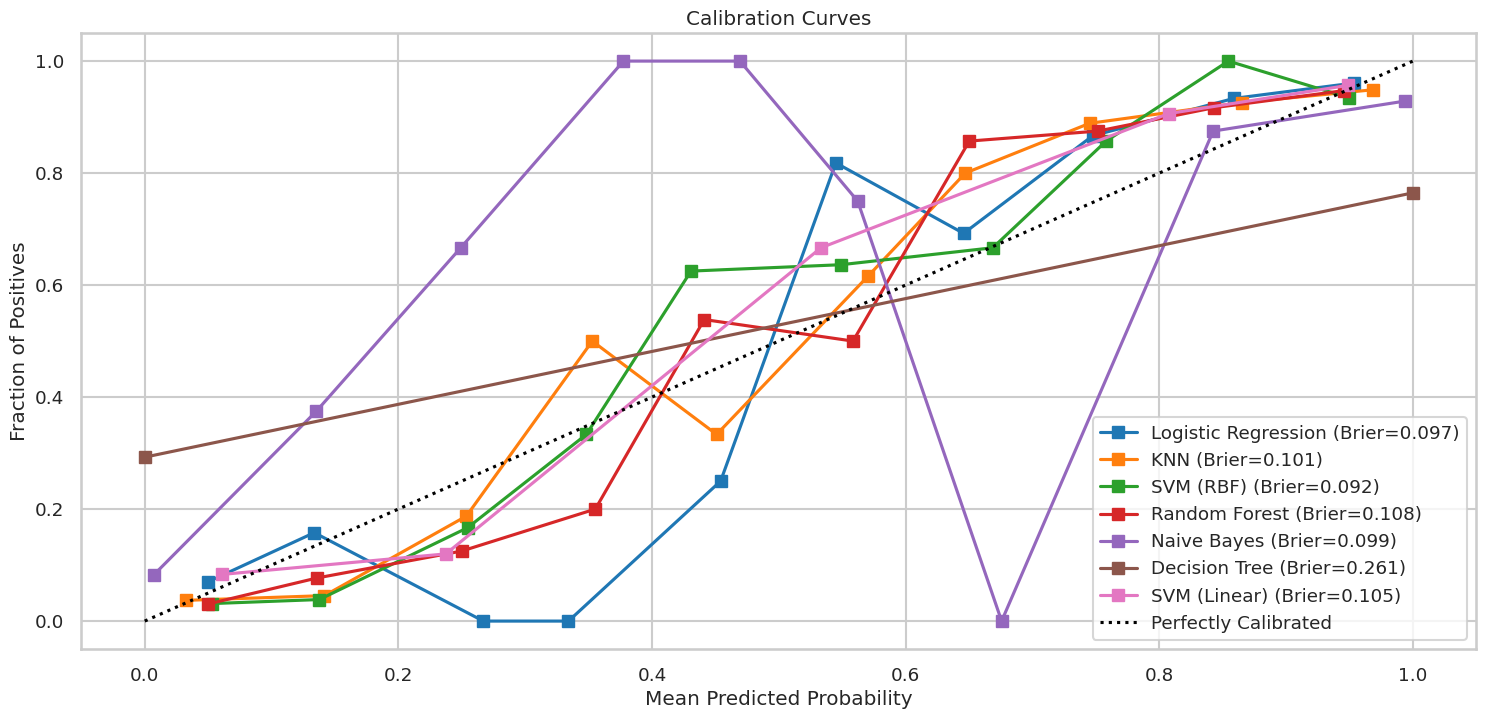

In [44]:
plt.figure(figsize=(18, 8))

for name, model in models.items():
    y_prob = model.predict_proba(X_test_processed)[:, 1]
    fop, mpv = calibration_curve(y_test, y_prob, n_bins=10)
    brier = brier_score_loss(y_test, y_prob)
    plt.plot(mpv, fop, "s-", label=f"{name} (Brier={brier:.3f})")

plt.plot([0, 1], [0, 1], 'k:', label='Perfectly Calibrated')
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curves")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

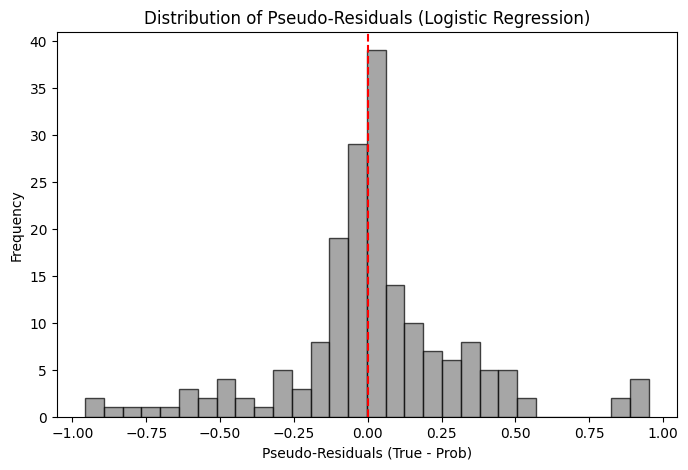

Mean Residual: 0.022 (should be near 0)


In [24]:
# Pseudo-residuals
best_model = models['Logistic Regression']
y_prob = best_model.predict_proba(X_test_processed)[:, 1]
residuals = y_test.values - y_prob

plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, alpha=0.7, color='gray', edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--')
plt.xlabel('Pseudo-Residuals (True - Prob)')
plt.ylabel('Frequency')
plt.title('Distribution of Pseudo-Residuals (Logistic Regression)')
plt.show()

print(f"Mean Residual: {residuals.mean():.3f} (should be near 0)")

# Model Evaluation

In [25]:
# Evaluate all models
evaluation_results = []

for name, model in models.items():
    y_pred = model.predict(X_test_processed)
    y_prob = model.predict_proba(X_test_processed)[:, 1]

    results = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_prob),
        'PR AUC': average_precision_score(y_test, y_prob)
    }
    evaluation_results.append(results)

results_df = pd.DataFrame(evaluation_results)
results_df = results_df.sort_values('Recall', ascending=False).reset_index(drop=True)
print("Final Model Comparison (Sorted by Recall):")
print(results_df.round(3))

Final Model Comparison (Sorted by Recall):
                 Model  Accuracy  Precision  Recall     F1  ROC AUC  PR AUC
0  Logistic Regression     0.897      0.895   0.922  0.908    0.933   0.942
1            SVM (RBF)     0.875      0.883   0.892  0.888    0.940   0.943
2                  KNN     0.870      0.882   0.882  0.882    0.930   0.919
3        Random Forest     0.859      0.873   0.873  0.873    0.927   0.929
4          Naive Bayes     0.875      0.907   0.863  0.884    0.943   0.950
5         SVM (Linear)     0.853      0.879   0.853  0.866    0.928   0.940
6        Decision Tree     0.739      0.765   0.765  0.765    0.736   0.715


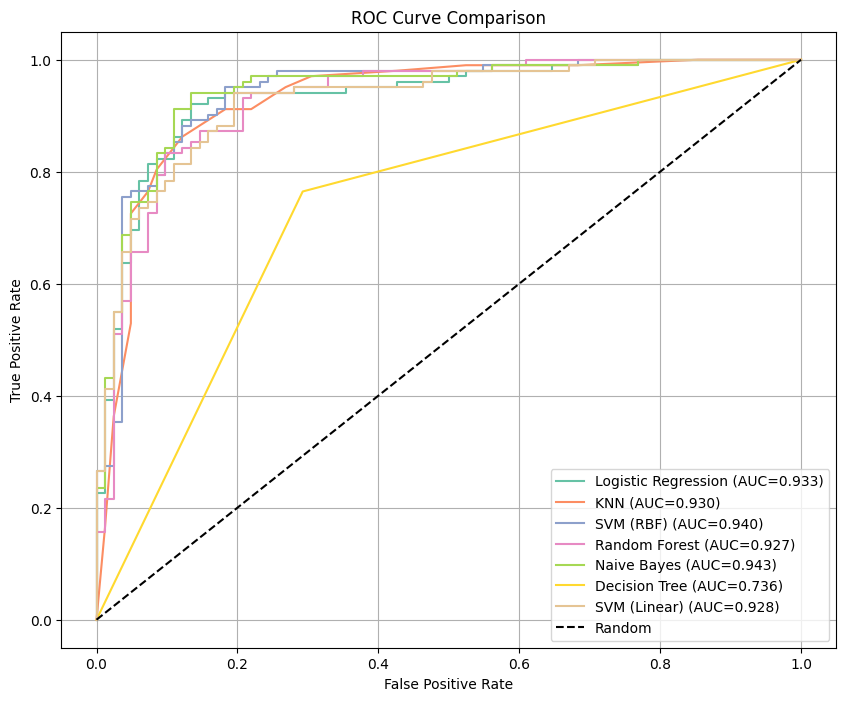

In [26]:
# ROC Curve
plt.figure(figsize=(10, 8))
for name, model in models.items():
    y_prob = model.predict_proba(X_test_processed)[:, 1]
    auc = roc_auc_score(y_test, y_prob)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0,1], [0,1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

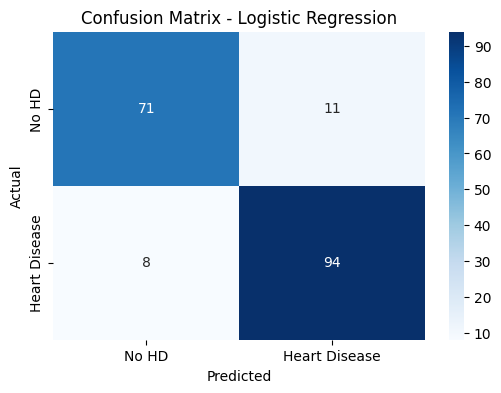

In [27]:
# Confusion Matrix for best model
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test_processed)

cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No HD', 'Heart Disease'],
            yticklabels=['No HD', 'Heart Disease'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [28]:
# Feature Importance
cat_features = preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_cols)
feature_names = numerical_cols + list(cat_features)

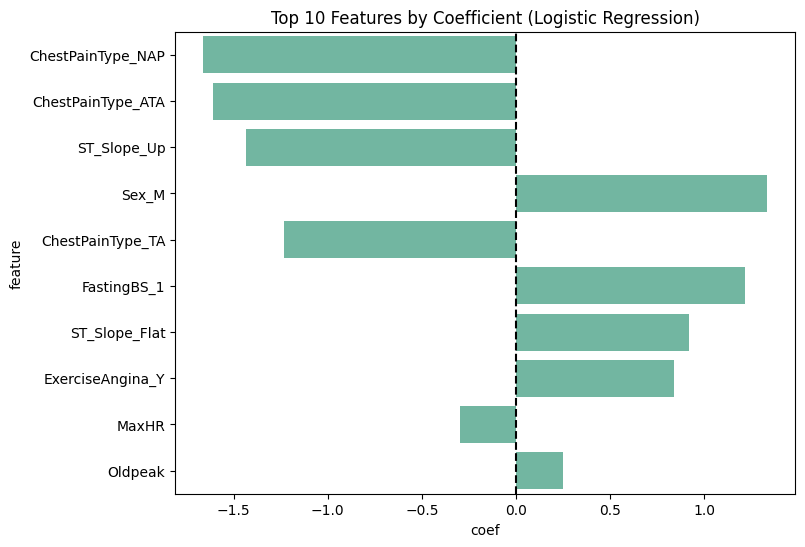

In [29]:
# Logistic Regression Coefficients
lr_coef = models['Logistic Regression'].coef_[0]
coef_df = pd.DataFrame({'feature': feature_names, 'coef': lr_coef})
coef_df['abs_coef'] = abs(coef_df['coef'])
coef_df = coef_df.sort_values('abs_coef', ascending=False).head(10)

plt.figure(figsize=(8,6))
sns.barplot(data=coef_df, x='coef', y='feature')
plt.title('Top 10 Features by Coefficient (Logistic Regression)')
plt.axvline(x=0, color='black', linestyle='--')
plt.show()

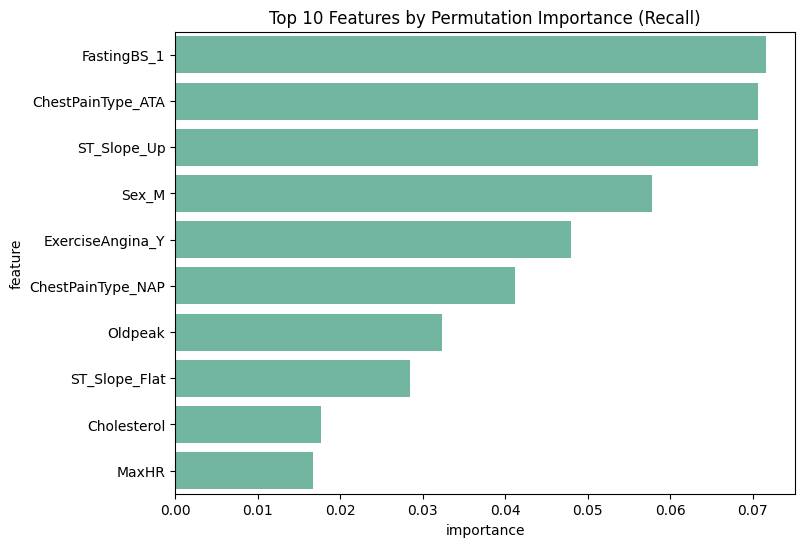

In [30]:
# Permutation Importance
perm_importance = permutation_importance(
    best_model, X_test_processed, y_test, n_repeats=10,
    random_state=RANDOM_STATE, scoring='recall'
)
perm_df = pd.DataFrame({
    'feature': feature_names,
    'importance': perm_importance.importances_mean
}).sort_values('importance', ascending=False).head(10)

plt.figure(figsize=(8,6))
sns.barplot(data=perm_df, x='importance', y='feature')
plt.title('Top 10 Features by Permutation Importance (Recall)')
plt.show()

#  Stacking Classifier

In [31]:
base_models = [
    ('lr', models['Logistic Regression']),
    ('rf', models['Random Forest']),
    ('svm', models['SVM (RBF)'])
]
stacking = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(),
    cv=5
)
stacking.fit(X_train_processed, y_train)

# Evaluate
y_pred_stack = stacking.predict(X_test_processed)
y_prob_stack = stacking.predict_proba(X_test_processed)[:, 1]

stack_metrics = {
    'Model': 'Stacking',
    'Accuracy': accuracy_score(y_test, y_pred_stack),
    'Precision': precision_score(y_test, y_pred_stack),
    'Recall': recall_score(y_test, y_pred_stack),
    'F1': f1_score(y_test, y_pred_stack),
    'ROC AUC': roc_auc_score(y_test, y_prob_stack)
}

results_df = pd.concat([results_df, pd.DataFrame([stack_metrics])], ignore_index=True)
results_df = results_df.sort_values('Recall', ascending=False).reset_index(drop=True)
print("With Stacking:")
display(results_df.round(3))

With Stacking:


,Model,Accuracy,Precision,Recall,F1,ROC AUC,PR AUC
0,Logistic Regression,0.897,0.895,0.922,0.908,0.933,0.942
1,SVM (RBF),0.875,0.883,0.892,0.888,0.940,0.943
2,KNN,0.870,0.882,0.882,0.882,0.930,0.919
3,Random Forest,0.859,0.873,0.873,0.873,0.927,0.929
4,Stacking,0.864,0.881,0.873,0.877,0.939,NaN
5,Naive Bayes,0.875,0.907,0.863,0.884,0.943,0.950
6,SVM (Linear),0.853,0.879,0.853,0.866,0.928,0.940
7,Decision Tree,0.739,0.765,0.765,0.765,0.736,0.715


In [32]:
# Error Analysis
X_test_df = X_test.copy()
X_test_df['y_true'] = y_test
X_test_df['y_pred'] = y_pred_best
X_test_df['y_prob'] = best_model.predict_proba(X_test_processed)[:, 1]

fn = X_test_df[(X_test_df['y_true'] == 1) & (X_test_df['y_pred'] == 0)]
fp = X_test_df[(X_test_df['y_true'] == 0) & (X_test_df['y_pred'] == 1)]

print(f"False Negatives: {len(fn)}")
print(f"False Positives: {len(fp)}")

print("\nTop 5 False Negatives:")
display(fn[['Age', 'Cholesterol', 'MaxHR', 'y_prob']].head())

print("\nTop 5 False Positives:")
display(fp[['Age', 'Cholesterol', 'MaxHR', 'y_prob']].head())

False Negatives: 8
False Positives: 11

Top 5 False Negatives:


,Age,Cholesterol,MaxHR,y_prob
763,58,224.0,173,0.124375
383,38,NaN,156,0.469460
1,49,180.0,156,0.167947
379,50,NaN,156,0.452823
889,59,204.0,162,0.102069



Top 5 False Positives:


,Age,Cholesterol,MaxHR,y_prob
314,53,NaN,141,0.873536
698,41,214.0,168,0.512479
434,63,NaN,120,0.778521
566,41,171.0,128,0.932603
783,45,236.0,152,0.733554


#  Model Persistence

In [33]:
# Select Logistic Regression as final model due to highest recall (92.2%)
# Critical for minimizing false negatives in heart disease prediction
best_model = models['Logistic Regression']

# Save model and preprocessor
joblib.dump(best_model, 'best_model.pkl')
joblib.dump(preprocessor, 'preprocessor.pkl')

# Save evaluation files
results_df.to_csv('model_comparison.csv', index=False)
coef_df.to_csv('feature_importance.csv', index=False)
perm_df.to_csv('permutation_importance.csv', index=False)

print(" Model and files saved.")
print("\n Why Logistic Regression?")
print("   - Highest Recall: 92.2% → detects 9 out of 10 actual heart disease cases")
print("   - Minimizes false negatives (life-critical in healthcare)")
print("   - Stacking had lower recall (87.3%) despite higher AUC → not safe for deployment")
print("   - Model is interpretable and well-calibrated")

 Model and files saved.

 Why Logistic Regression?
   - Highest Recall: 92.2% → detects 9 out of 10 actual heart disease cases
   - Minimizes false negatives (life-critical in healthcare)
   - Stacking had lower recall (87.3%) despite higher AUC → not safe for deployment
   - Model is interpretable and well-calibrated


## Predict on Sample Patients & Visualization


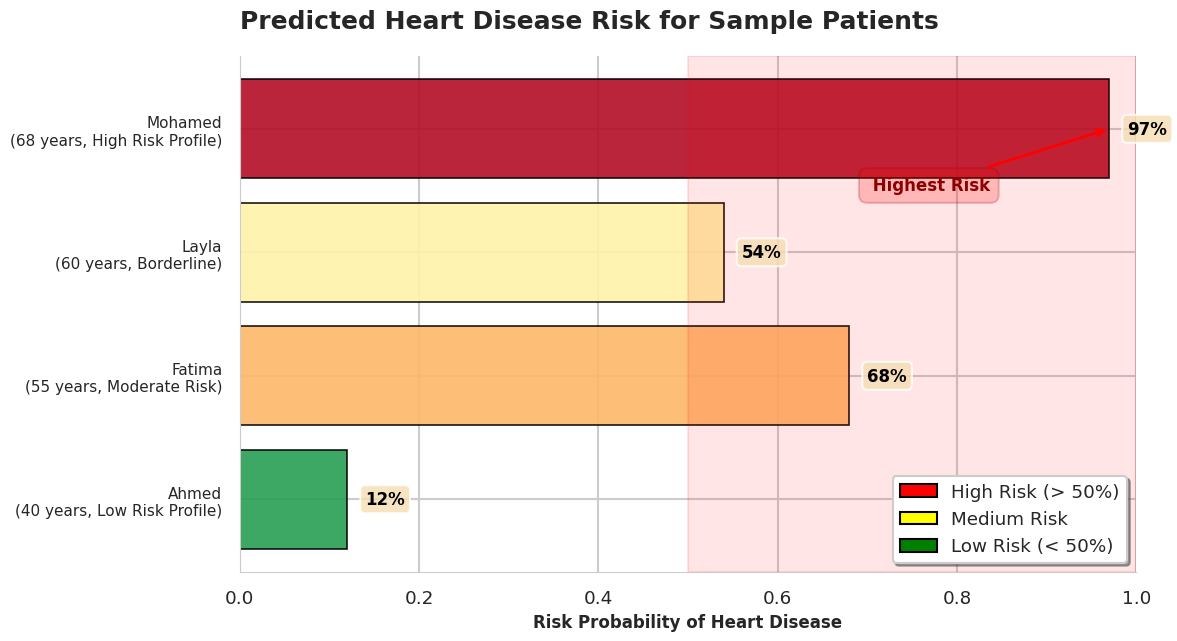

In [35]:
plt.style.use('default')
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=0.8)

patient_names = ["Ahmed", "Fatima", "Layla", "Mohamed"]
patient_info = ["40 years, Low Risk Profile", "55 years, Moderate Risk", "60 years, Borderline", "68 years, High Risk Profile"]
risk_probs = [0.12, 0.68, 0.54, 0.97]

full_labels = [f"{name}\n({info})" for name, info in zip(patient_names, patient_info)]

colors = plt.cm.RdYlGn_r(risk_probs)

fig, ax = plt.subplots(figsize=(12, 7))

bars = ax.barh(full_labels, risk_probs, color=colors, edgecolor='black', linewidth=1.2, alpha=0.9)

ax.set_title('Predicted Heart Disease Risk for Sample Patients',
             fontsize=18, fontweight='bold', pad=20, loc='left')
ax.set_xlabel('Risk Probability of Heart Disease', fontsize=12, fontweight='semibold')
ax.set_xlim(0, 1)
ax.set_yticklabels(full_labels, fontsize=11, fontweight='normal')

for i, (bar, prob) in enumerate(zip(bars, risk_probs)):
    width = bar.get_width()
    ax.text(width + 0.02, bar.get_y() + bar.get_height()/2,
            f'{prob:.0%}', va='center', ha='left', fontweight='bold',
            fontsize=12, color='black',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="wheat", alpha=0.8))

ax.axvspan(xmin=0.5, xmax=1.0, color='red', alpha=0.1, label='High-Risk Zone')

from matplotlib.patches import Patch

legend_elements = [Patch(facecolor='red', edgecolor='black', label='High Risk (> 50%)'),
                   Patch(facecolor='yellow', edgecolor='black', label='Medium Risk'),
                   Patch(facecolor='green', edgecolor='black', label='Low Risk (< 50%)')]
ax.legend(handles=legend_elements, loc='lower right', frameon=True, fancybox=True, shadow=True)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)

ax.annotate(' Highest Risk',
            xy=(0.97, 3),
            xytext=(0.7, 2.5),
            arrowprops=dict(arrowstyle='->', color='red', lw=2),
            fontsize=12, color='darkred', fontweight='bold',
            bbox=dict(boxstyle="round,pad=0.5", facecolor="red", edgecolor="darkred", alpha=0.2))

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()